In [69]:
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from time import time
from datetime import timedelta

In [70]:
energy_temperature_df = pd.read_excel('data/ET Kurver.xlsx')

In [71]:
energy_temperature_df.loc[278]

 Bygg         Trondheim Kommune - Voldsminde barnehage
Fra                                         04.01.2016
DX1                                                NaN
DX2                                              -15.0
DX3                                               -1.4
DX4                                                4.6
DX5                                               10.5
DX6                                               25.0
DY1                                                NaN
DY2                                            12800.0
DY3                                             8000.0
DY4                                             5800.0
DY5                                             2900.0
DY6                                             2900.0
ETXMin                                             -15
ETXMax                                              25
ETYMin                                               0
ETXMax.1                                         15000
Grunnlast 

In [72]:
def linear_interpolation(x, x0, y0, x1, y1):
    if x == x0:
        return y0
    if x == x1:
        return y1

    slope = (y1 - y0) / (x1 - x0)
    return y0 + (x - x0) * slope

class et_curve():
    def __init__(self, baseline, dx, dy):
        self.baseline = baseline
        self.dx = dx
        self.dy = dy

    def expected(self, temperature):
        if temperature < self.dx[0]:
            print(f'{temperature} is below range, lowest point is ({self.dx[0]}, {self.dy[0]})')
            # TODO improve this prediction
            return self.dy[0]
        if temperature > self.dx[-1]:
            print(f'{temperature} is above range, highest point is ({self.dx[-1]}, {self.dy[-1]})')
            return self.dy[-1]

        for i in range(len(self.dx) - 1):
            if self.dx[i] <= temperature and temperature <= self.dx[i+1]:
                return linear_interpolation(temperature, self.dx[i], self.dy[i], self.dx[i+1], self.dy[i+1])

        return None


In [73]:
def et_curve_from_pandas_row(row: pd.core.series.Series) -> et_curve:
    baseline = row['Grunnlast']

    dx = []
    dy = []
    for i in range(1,7):
        x = row[f'DX{i}']
        y = row[f'DY{i}']
        if (not np.isnan(x)) and (not np.isnan(y)):
            dx.append(x)
            dy.append(y)

    return et_curve(baseline, dx, dy)


In [74]:
test_et = et_curve_from_pandas_row(energy_temperature_df.loc[278])

for i in range(-20, 22):
    prediction = test_et.expected(i)
    print(f'temp: {i} expected: {prediction:.1f} kWh/uke')


-20 is below range, lowest point is (-15.0, 12800.0)
temp: -20 expected: 12800.0 kWh/uke
-19 is below range, lowest point is (-15.0, 12800.0)
temp: -19 expected: 12800.0 kWh/uke
-18 is below range, lowest point is (-15.0, 12800.0)
temp: -18 expected: 12800.0 kWh/uke
-17 is below range, lowest point is (-15.0, 12800.0)
temp: -17 expected: 12800.0 kWh/uke
-16 is below range, lowest point is (-15.0, 12800.0)
temp: -16 expected: 12800.0 kWh/uke
temp: -15 expected: 12800.0 kWh/uke
temp: -14 expected: 12447.1 kWh/uke
temp: -13 expected: 12094.1 kWh/uke
temp: -12 expected: 11741.2 kWh/uke
temp: -11 expected: 11388.2 kWh/uke
temp: -10 expected: 11035.3 kWh/uke
temp: -9 expected: 10682.4 kWh/uke
temp: -8 expected: 10329.4 kWh/uke
temp: -7 expected: 9976.5 kWh/uke
temp: -6 expected: 9623.5 kWh/uke
temp: -5 expected: 9270.6 kWh/uke
temp: -4 expected: 8917.6 kWh/uke
temp: -3 expected: 8564.7 kWh/uke
temp: -2 expected: 8211.8 kWh/uke
temp: -1 expected: 7853.3 kWh/uke
temp: 0 expected: 7486.7 kWh/uk

In [75]:
energy_consumption_and_temp_df = pd.read_excel('data/EsaveExport_Trondheim Kommune_Trondheim_10121314.xls', parse_dates=['Unnamed: 0'], decimal=',', sheet_name='Export_4')
energy_consumption_and_temp_df.rename(columns={'Unnamed: 0': 'datetime'}, inplace=True)
energy_consumption_and_temp_df.set_index('datetime', inplace=True)

In [76]:
temp_voll = energy_consumption_and_temp_df['Eklima_68860_TAM']

In [77]:
temp_voll

datetime
2015-01-01 00:00:00    3.6
2015-01-01 01:00:00    3.6
2015-01-01 02:00:00    3.6
2015-01-01 03:00:00    3.6
2015-01-01 04:00:00    3.6
                      ... 
2020-01-01 19:00:00    7.4
2020-01-01 20:00:00    7.4
2020-01-01 21:00:00    7.4
2020-01-01 22:00:00    7.4
2020-01-01 23:00:00    7.4
Name: Eklima_68860_TAM, Length: 43848, dtype: float64

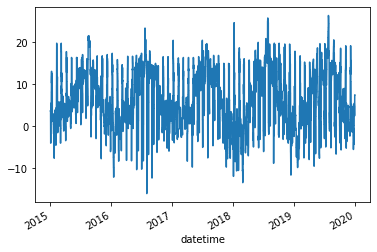

In [78]:
temp_voll.plot()
plt.show()

In [79]:
energy_consumption_and_temp_weekly_df = energy_consumption_and_temp_df.resample('W-MON').sum()

In [80]:
energy_consumption_df = pd.read_excel('data/EsaveExport_Trondheim Kommune_Trondheim_10121314.xls', parse_dates=['Unnamed: 0'], decimal=',', sheet_name='Export_1')
energy_consumption_df.rename(columns={'Unnamed: 0': 'datetime'}, inplace=True)
energy_consumption_df.set_index('datetime', inplace=True)
energy_consumption_weekly_df = energy_consumption_df.resample('W-MON').sum()

In [81]:
energy_consumption_weekly_df['707057500068616428']

datetime
2015-01-05     927.2
2015-01-12    1954.4
2015-01-19    2065.0
2015-01-26    2189.0
2015-02-02    2391.4
               ...  
2019-12-09    1930.0
2019-12-16    1806.0
2019-12-23    1975.0
2019-12-30    1364.0
2020-01-06     307.0
Freq: W-MON, Name: 707057500068616428, Length: 262, dtype: float64

In [82]:
energy_consumption_weekly_series = energy_consumption_weekly_df['707057500068616428'] + energy_consumption_weekly_df['ESAVE_89434-980396002_EAN']

In [83]:
temp_voll_weekly_mean = temp_voll.resample('W-MON').mean()

In [84]:
et_prediction_weekly = temp_voll_weekly_mean.apply(test_et.expected)

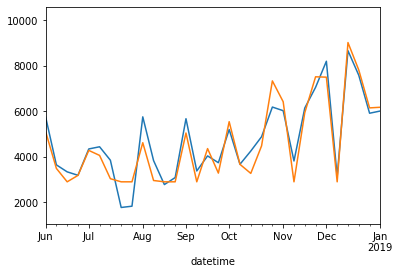

In [85]:
start_plot = datetime(2018, 6, 1, 1)
stop_plot = datetime(2019, 1, 1, 0)

energy_consumption_weekly_series.plot(xlim=(start_plot, stop_plot))
et_prediction_weekly.plot(xlim=(start_plot, stop_plot))
plt.show()